# CS 190I Homework 3: Multi-class classification in pytorch
In this machine problem (MP), you will train a neural network to classify textual sequences. You will use `torch.nn` to implement a neural network and use `torch.autograd` to calculate the gradient and train your model.

## Basic classes and functions in Pytorch

### [torch.autograd](https://pytorch.org/docs/stable/autograd.html)

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions. To obtain gradients for a tensor via autograd from arbitrary scalar valued functions, you can simply set `requires_grad=True`. Then you can call `backward()` on any scalar that you want to calculate gradient of. The gradients will be accumulated in the `.grad` attribute. You can refer to [this tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) for more information.

For example, let's calculate $∇_\boldsymbol{x}||\boldsymbol{x}||^2$ and verify if it equals $2\boldsymbol{x}$.

In [ ]:
# Include packages
import math
import torch
from torch import nn
import random
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
%matplotlib inline

In [ ]:
x = torch.randn(5, requires_grad=True)
norm_square = (x**2).sum()

# calculate gradient
norm_square.backward()

print(f"2x is: {2 * x.data}")
print(f"gradient is: {x.grad}")

2x is: tensor([-0.4976,  0.5438, -1.7445,  2.2233,  2.1993])
gradient is: tensor([-0.4976,  0.5438, -1.7445,  2.2233,  2.1993])


**Note:** the gradient is accumulated in the `.grad` attribute, so you need to clear the accumulated gradients before every iteration.

### [torch.nn](https://pytorch.org/docs/stable/nn.html#)
The `torch.nn` package defines a set of Modules, including all kinds of layers you might use in a neural network, loss functions, weight initialization functions, etc. In this notebook, we will introduce the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) in `torch.nn`, which define a set of functions you might use for various problems such as regression and classification.

For example, the following cell illustrates the use of `nn.MSELoss` to calculate the mean squared error.

In [ ]:
x = torch.randn(5)
y = torch.randn(5)

# calculate MSE with torch
mse_th = ((x - y)**2).mean()
print(f"MSE using tensor operations: {mse_th}")

# calculate MSE with nn.MESLoss
loss_func = nn.MSELoss()
mse_nn = loss_func(x, y)
print(f"MSE using nn: {mse_nn}")

MSE using tensor operations: 2.277683734893799
MSE using nn: 2.277683734893799


### [torch.optim](https://pytorch.org/docs/stable/optim.html)
In previous homeworks, you manually update the parameters after calcuting the gradients. In fact, `torch.optim` implements various optimization algorithms such as SGD, which you can use to conveniently update your parameters. To do that, you simply need to create an optimizer (e.g., `torch.optim.SGD`) by specifying the parameters that need to be updated and associated optimization hyperparameters such as learning rate. In the training loop, you will need to modify your code to include the following two steps:
- Use `optimizer.zero_grad()` to clear gradients of parameters.
- Use `optimizer.step()` to automatically update parameters.

You can refer to [this tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) for more details and examples.

## Homework: Text Classification with Pytorch

In this problem, you will create a text-classification model thtat classifys whether a given movie review is positive or negative. We experiment with the dataset called [SST-2](https://nlp.stanford.edu/sentiment/).


**Download SST-2 dataset**

We provide you with the utility function that downloads and extracts document strings from raw SST-2 dataset.

In [ ]:
import random
import requests
import zipfile
import csv

def download_and_extract(url, local_filename, extract_dir):
    try:
        # Download the file
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"Failed to download {url}. Status code: {response.status_code}")
        # Save to local file
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        # Extract the file
        with zipfile.ZipFile(local_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted {local_filename} to {extract_dir} successfully.")
    except Exception as e:
        print(f"Error: {e}")

def read_sst2(path, maxidx=None):
    data = {'documents' : [], 'labels' : []}
    with open(path, newline="", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile, delimiter="\t")
        for i, row in enumerate(reader):
            text = row["sentence"]
            label = int(row["label"])  # Convert the label to an integer (0 or 1)
            data['documents'].append(text)
            data['labels'].append(label)

            if i == maxidx:
                break
    print("Loaded ", len(data['documents']), " sample from ", path)
    return data

SST2_URL = "https://dl.fbaipublicfiles.com/glue/data/SST-2.zip"
download_and_extract(SST2_URL, 'sst2.zip', '.')
sst2_train = read_sst2("SST-2/train.tsv", )
sst2_dev = read_sst2("SST-2/dev.tsv", )
for _ in range(3):
    idx = random.randint(0, len(sst2_train['documents']))
    print(f"Example {idx}: {sst2_train['documents'][idx]}\tLabel: {sst2_train['labels'][idx]}")

Extracted sst2.zip to . successfully.
Loaded  67349  sample from  SST-2/train.tsv
Loaded  872  sample from  SST-2/dev.tsv
Example 61702: a hilarious ode to middle america and middle age with this unlikely odyssey 	Label: 1
Example 12967: it , offering fine acting moments and pungent 	Label: 1
Example 15012: this slight premise 	Label: 0


Similar to the classification on MNIST where we convert raw images into raw image features. We first need to convert the raw movie review string into a common text feature: [**bag-of-words**](https://www.wikiwand.com/en/Bag-of-words_model).


**Tokenize**

In natural language processing, we always first split the full text into small pieces, i.e., tokens. This process is called **tokenize**, which helps us construct a sequence of integers to represent the text.

Below, you need to implement one basic tokenize function on the *documents*, that splits document string into a list of words and convert each word into corresponding integer index that represents the word.

More specifically, you need to implement following functions (details in the following cell):

**normalize(document)**: a function that lowercases all characters in the document and adds whitespace before and after ".,!?:;" characters.

**build_vocab(documents)**: a function that finds all unique words in the documents and creates a dictionary mapping from word to integer index in the vocabulary. Remember to add a special **\<unk\>** token into vocaboluary.

**tokenize(vocab2id, document)**: a function that first split document into a sequence of words and then convert words into corresponding indices in the vocabulary. For unkown words, use the index of **\<unk\>**.

**bag_of_words(vocab2id, documents)**: a function that constructs **bag-of-words** feature of documents. Bag of words is represented as a unordered collection of words.

In [ ]:
documents = [
    "This is, the first document.",
    "This document , is the second document.",
    "And this is the third one.",
    "Is this the first document?",
    "How many documents are here"
]

In [ ]:
import numpy as np
from collections import Counter
import re
punc = ['.', ',', '!', '?', ';', ':', '#', '$', '&', "'", '(', ')', '*', '+', '/']
# , '-'
def normalize(document):
    ## TODO:
    ## 1. Lowercase all characters in the document.
    ## 2. Add white space before and after following punctuation marks .,!?;:
    # for i in range(len(document)):
    #   document[i] = document[i].lower()
    #   for j in range(len(document[i])):
    #     if(document[i][j] == '.' or document[i][j] == ',' or document[i][j] == '!' or document[i][j] == '?' or document[i][j] == ';' or document[i][j] == ':'):
    #         print(type(document[i][j]))
    #         document[i][j] = ' ' + document[i][j] + ' '
    document = document.lower()
    # document_list = list(document)
    # for j in range(len(document_list)):
    #     if document_list[j] in punc:
    #         document_list[j] = ' ' + document_list[j] + ' '
    # document = ''.join(document_list)
    document = re.sub(r'([.!?;:])', r' \1 ', document)
    ## END OF YOUR CODE
    return document

def build_vocab(documents):
    # Build vocabulary
    vocabulary = set()

    for document in documents:
        ## TODO: normalize document, split the document into words and find the unique words
        document = normalize(document)
        doc_words = document.split()
        # doc_words = [word for word in doc_words if word not in punc]
        for word in doc_words:
          vocabulary.add(word)
        ## END OF YOUR CODE

    vocabulary = sorted(list(vocabulary))
    assert "<unk>" not in vocabulary

    ## TODO: insert the <unk> token into the vocabulary
    vocabulary.insert(0, "<unk>")
    ## END OF YOUR CODE

    word2id = {} # A dictionary that maps from word to integer index in the vocabulary
    ## TODO: construct a mapping from word string into an integer index
    for idx, word in enumerate(vocabulary, start = 0):
      word2id[word] = idx
    ## END OF YOUR CODE

    print("Number of unique words: ", len(vocabulary))
    print("The words are", vocabulary)
    print("Word to id dict is: ", word2id)
    return vocabulary, word2id

def tokenize(word2id, document):
    document = normalize(document)
    doc_words = document.split()
    # doc_words = [word for word in doc_words if word not in punc]
    wordids = []
    for word in doc_words:
      wordids.append(word2id.get(word, word2id["<unk>"]))
    ## TODO: Tokenize the document string into a list of integers called wordids

    ## END OF YOUR CODE
    return wordids

def bag_of_words_doc(word2id, document):
    feature = None
    ## TODO: Construct bag of word feature for a document
    document = normalize(document)
    doc_words = document.split()

    # doc_words = [word for word in doc_words if word not in punc]
    feature =  [0] * len(word2id)

    word_counts = Counter(doc_words)

    for word, count in word_counts.items():
      if word in word2id:
            feature[word2id[word]] = count

    # ids = tokenize(word2id, document)
    # for id in ids:
    #   feature[id] += 1

    ## END OF YOUR CODE
    return feature

vocab, word2id = build_vocab(documents)
document = documents[0]
print("Input document: ", document)
print("Tokenize result: ", tokenize(word2id, document))
print("Document bag of words feature: ", bag_of_words_doc(word2id, document))

Number of unique words:  19
The words are ['<unk>', ',', '.', '?', 'and', 'are', 'document', 'documents', 'first', 'here', 'how', 'is', 'is,', 'many', 'one', 'second', 'the', 'third', 'this']
Word to id dict is:  {'<unk>': 0, ',': 1, '.': 2, '?': 3, 'and': 4, 'are': 5, 'document': 6, 'documents': 7, 'first': 8, 'here': 9, 'how': 10, 'is': 11, 'is,': 12, 'many': 13, 'one': 14, 'second': 15, 'the': 16, 'third': 17, 'this': 18}
Input document:  This is, the first document.
Tokenize result:  [18, 12, 16, 8, 6, 2]
Document bag of words feature:  [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]


Now create a vocabulary using the entire SST-2 training set.

In [ ]:
vocab, word2id = build_vocab(sst2_train['documents'])

Number of unique words:  14775
The words are ['<unk>', '!', '#', '$', '&', "'", "''", "'30s", "'40s", "'50s", "'53", "'60s", "'70s", "'80s", "'90s", "'d", "'em", "'ll", "'m", "'n", "'n'", "'re", "'s", "'til", "'ve", '(', ')', '*', '***', '****', '+', ',', '-', '--', '.', '/', '1', '1/2', '10', '10,000', '10-course', '10-year', '10-year-old', '100', '100-minute', '101', '103-minute', '105', '10th', '10th-grade', '11', '110', '112-minute', '12-year-old', '120', '127', '129-minute', '12th', '13', '13th', '14-year-old', '140', '146', '15', '15-year', '15th', '163', '168-minute', '170', '1790', '18', '18-year-old', '1899', '19', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '19th-century', '2', '2,500', '2-day', '2/3', '20', '20-car', '2000', '2001', '2002', '20t

In [ ]:
# print("Creating Train Tensor...")
# size = len(sst2_train['documents'])
# train_tensor = torch.zeros(0, len(vocab))
# for i, doc in enumerate(sst2_train['documents']):
#   if(i % 675 == 0):
#     print(i)
#   new_row = [tokenize(word2id, doc)]
#   sst2_train['documents'][i] = new_row
# print("Complete")

In [ ]:
# print(sst2_train)

In [ ]:
# torch.save(sst2_train, "sst2_train.pt")

In [ ]:
# w)print(f)

In [ ]:
# print("Creating Accuracy Tensor...")
# print(len(sst2_dev['documents']))
# for i, doc in enumerate(sst2_dev['documents']):
#   if(i % 675 == 0):
#     print(i)
#   new_row = torch.tensor([tokenize(word2id, doc)])
#   sst2_dev['documents'][i] = new_row
# print("Complete")

In [ ]:
# torch.save(sst2_dev, "sst2_dev.pt")

In [ ]:
# example = torch.load("sst2_train.pt", weights_only=False)
# print(example['documents'])

**Train MLP on SST2**

Implement a two-layer MLP with ReLU activation function for the binary classification task on SST-2. Use Cross Entropy loss (or equivalently negative loglikelihood) to train the model. Complete the `train_mlp_sst()` function to train your model, visualize the training losses and validation loss, and report the accuracy on validation set. Remember to tokenize the data on the fly during training to save memory.

In [ ]:
class TwoLayerMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        '''
        Create a two-layer fully-connected network
        Inputs:
        input_dim: dimension of input features
        hidden_dim: dimension of hidden layer
        output_dim: dimension of output
        '''
        super().__init__()
        ## TODO: define layers in the model
        ## Model architecture: input --> hidden layer --> output
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        ## End of your code

    def forward(self, x):
        logits = None
        ## TODO: forward pass

        #Hidden Layer
        logits = self.hidden_layer(x)

        #ReLu Func
        logits = torch.relu(logits)

        #Output Layer
        logits = self.output_layer(logits)

        ## End of your code
        return logits

In [ ]:
def visualize_loss_acc(losses, accs, split):
    '''
    This function plots the loss curve and accuracy curve using matplotlib.
    '''

    losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in losses]
    accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in accs]

    # use matplotlib plot train curves
    plt.figure(figsize=(6, 10))
    plt.subplot(2, 1, 1)

    plt.plot(range(len(losses)), losses)
    plt.xlabel('Iter #')
    plt.ylabel('Loss')
    plt.title(f'{split} loss vs iteration number')

    plt.subplot(2, 1, 2)
    plt.plot(range(len(accs)), accs)
    plt.xlabel('Iter #')
    plt.ylabel('Acc')
    plt.title(f'{split} accuracy vs iteration number')

    # Show the figure.
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Creating Accuracy Tensor...")
val_tensor = torch.zeros(0, len(vocab))
for doc in sst2_dev['documents']:
  new_row = torch.tensor([bag_of_words_doc(word2id, doc)])
  val_tensor = torch.cat((val_tensor, new_row), dim=0)
val_truth = torch.tensor(sst2_dev['labels'])
print("Complete")
val_tensor = val_tensor.to(device)
val_truth = val_truth.to(device)

Creating Accuracy Tensor...
Complete


In [ ]:
def train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_val):
    '''
    This function trains the model using stochastic gradient desent on the dataset.
    Returns:
    model: the optimized model.
    '''

    losses = []
    accs = []
    val_losses = []
    val_accs = []

    ## TODO: define loss function and optimizer, use SGD optimizer
    cross_entropy_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #sst2_train tensor
    # print("Creating Train Tensor...")
    # train_tensor = torch.zeros(0, len(vocab))
    # for i, doc in enumerate(sst2_train['documents']):
    #   print(f"{i}/{len(sst2_train['documents'])}")
    #   new_row = torch.tensor([tokenize(word2id, doc)])
    #   train_tensor = torch.cat((train_tensor, new_row), dim=0)
    #   sst2_train['documents'][i] = new_row
    # print("Complete")
    # print(sst2_train)

    # print("Creating Train Tensor...")
    # train_tensor = torch.zeros(0, len(vocab))
    # size = len(sst2_train['documents'])
    # for i, doc in enumerate(sst2_train['documents']):
    #   if(i % 675 == 0):
    #     print(i)
    #   new_row = torch.tensor([tokenize(word2id, doc)])
    #   # sst2_train['documents'][i] = new_row
    #   train_tensor = torch.cat((train_tensor, new_row), dim=0)
    # print("Complete")

    #sst2_val tensor for Accuracies
    # print("Creating Accuracy Tensor...")
    # val_tensor = torch.zeros(0, len(vocab))
    # for doc in sst2_val['documents']:
    #   new_row = torch.tensor([tokenize(word2id, doc)])
    #   val_tensor = torch.cat((val_tensor, new_row), dim=0)
    # val_truth = torch.tensor(sst2_val['labels'])
    # print("Complete")
    # End of your code

    # Train loop
    # If implemented correctly, it should take <15 seconds for an epoch
    for i in tqdm(range(num_epochs)):
        ## TODO: shuffle training data
        model.train()

        documents_t = np.array(sst2_train['documents'])
        label_t = np.array(sst2_train['labels'])
        idx = np.random.permutation(len(documents_t))
        # print(sst2_train['labels'])
        sst2_train['documents'] = documents_t[idx]
        sst2_train['labels'] = label_t[idx]
        # print(sst2_train['labels'])

        ## End of your code

        total_loss = 0;
        accuracy = 0;
        epoch_step = math.ceil(len(sst2_train['documents']) / batch_size)
        for j in range(epoch_step):
            # print(f"{j}/{epoch_step} step in {i}/{num_epochs} epoch")
            ## TODO: get features and labels for the batch: dynamically convert raw document string into feature tensors
            ## TODO: calculate loss and gradient
            ## TODO: update parameters
            ## Note: remember to clear gradients before every iteration

            #Splits into batches
            batch_idx = idx[j * batch_size : (j+1) * batch_size]

            #Gets a feature tensor for the Batch
            # batch_tensor = torch.zeros(0, len(vocab))
            # batch_tensor = torch.tensor(sst2_train['documents'][batch_idx])
            # for doc in sst2_train['documents'][batch_idx]:
            #   new_row = torch.tensor(doc)
            #   batch_tensor = torch.cat((batch_tensor, new_row), dim=0)
            # batch_tensor = torch.zeros(0, len(vocab))
            batch_tensor = torch.stack([torch.tensor(bag_of_words_doc(word2id, doc), dtype=torch.float) for doc in sst2_train['documents'][batch_idx]]).to(device)
            # print(batch_tensor.shape)
            # print(batch_tensor)

            #Labels for the batch
            # sst2_train['labels'][batch_idx]

            #Predictions
            pred = model(batch_tensor)
            # pred = pred.to(device="cuda")

            #Loss between prediction and the truth
            y_truth = torch.tensor(sst2_train['labels'][batch_idx], dtype=torch.long).to(device)
            loss = cross_entropy_loss(pred, y_truth)

            #Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Loss and Acc
            total_loss += loss.item()
            predicted_classes = torch.argmax(pred, dim=1)
            accuracy += (predicted_classes == y_truth).sum().item()

            ## End of your code
        loss, acc, val_loss, val_acc = None, None, None, None

        ## TODO: calculate loss, predictions, and accuracy
        ## Remember to wrap the computaions in torch.no_grad so that no computation graph is built
        model.eval()
        with torch.no_grad():

          loss = total_loss / epoch_step

          acc = accuracy / len(sst2_train['labels']) * 100

          val_pred = model(val_tensor)

          val_loss = cross_entropy_loss(val_pred, val_truth)

          predicted_val_classes = torch.argmax(val_pred, dim=1)
          val_acc = (predicted_val_classes == val_truth).sum().item()
          val_acc = val_acc / len(sst2_val['labels']) * 100

        ## End of your code
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Loss: {loss}")
        print(f"Accuracy: {acc}")
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {val_acc}")
        print("\n")

    print("Training done")
    visualize_loss_acc(losses, accs, "Training")
    visualize_loss_acc(val_losses, val_accs, "Validation")
    return model

  0%|          | 0/10 [00:00<?, ?it/s]

0/264 step in 0/10 epoch
1/264 step in 0/10 epoch
2/264 step in 0/10 epoch
3/264 step in 0/10 epoch
4/264 step in 0/10 epoch
5/264 step in 0/10 epoch
6/264 step in 0/10 epoch
7/264 step in 0/10 epoch
8/264 step in 0/10 epoch
9/264 step in 0/10 epoch
10/264 step in 0/10 epoch
11/264 step in 0/10 epoch
12/264 step in 0/10 epoch
13/264 step in 0/10 epoch
14/264 step in 0/10 epoch
15/264 step in 0/10 epoch
16/264 step in 0/10 epoch
17/264 step in 0/10 epoch
18/264 step in 0/10 epoch
19/264 step in 0/10 epoch
20/264 step in 0/10 epoch
21/264 step in 0/10 epoch
22/264 step in 0/10 epoch
23/264 step in 0/10 epoch
24/264 step in 0/10 epoch
25/264 step in 0/10 epoch
26/264 step in 0/10 epoch
27/264 step in 0/10 epoch
28/264 step in 0/10 epoch
29/264 step in 0/10 epoch
30/264 step in 0/10 epoch
31/264 step in 0/10 epoch
32/264 step in 0/10 epoch
33/264 step in 0/10 epoch
34/264 step in 0/10 epoch
35/264 step in 0/10 epoch
36/264 step in 0/10 epoch
37/264 step in 0/10 epoch
38/264 step in 0/10 ep

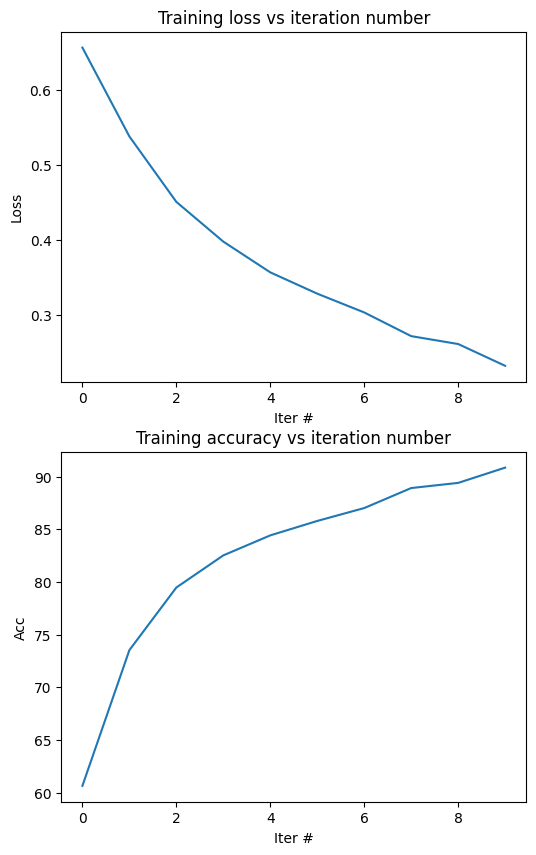

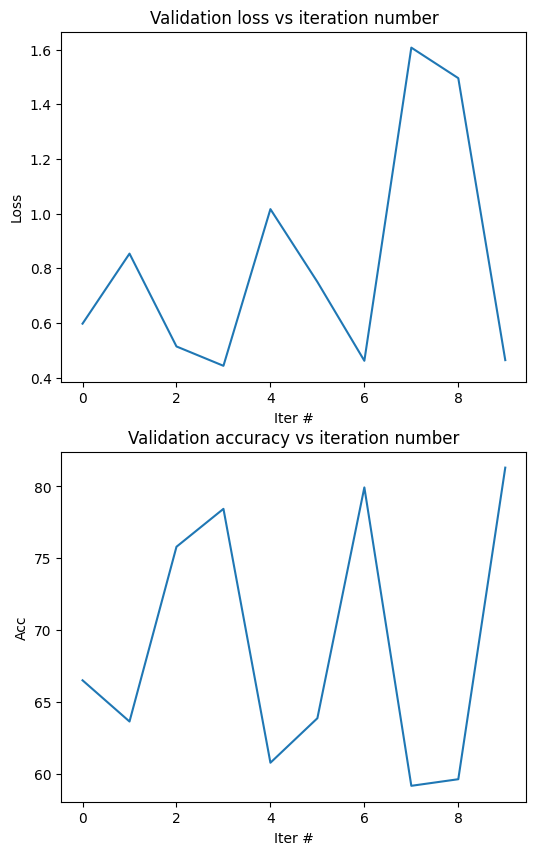

In [ ]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
# num_epochs = 5
batch_size = 256
lr = 0.2
hidden_dim = 128 # use this as hidden layer dimension

model = None
#################################
## TODO: initialize model      ##
#################################
# print(len(word2id))
model = TwoLayerMLP(len(word2id), hidden_dim, 2)
model = model.to(device)
# print(next(model.parameters()).device)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

**Effect of number of layers**

Experiment with different hyper-parameters: try number of layers with 3, 5, 10. You need to implement a new model class called `NLayerMLP` that takes the number of layers as hyper-parameter and constructs an MLP with multiple layers.

Visualize the training loss and validation loss (visualize validation loss at the end of each epoch), discuss your findings

In [ ]:
class NLayerMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, num_layers: int):
        '''
        Create a N-layer fully-connect network
        Inputs:
        input_dim: dimension of input features
        hidden_dim: dimension of hidden layer
        output_dim: dimension of output
        num_layers: number of hidden layers
        '''
        super().__init__()
        ## TODO: define layers in the model
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)

        layer_num = 1
        self.hidden_layers = nn.ModuleList()

        while layer_num < num_layers:
          self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
          layer_num += 1

        self.output_layer = nn.Linear(hidden_dim, output_dim)
        ## End of your code

    def forward(self, x):
        logits = None
        ## TODO: forward pass

        logits = torch.relu(self.hidden_layer(x))

        for layer in self.hidden_layers:
            x = torch.relu(layer(logits))

        ## End of your code
        return logits

  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.685795821249485
Accuracy: 55.72614292714071
Validation Loss: 0.6907050013542175
Validation Accuracy: 50.917431192660544


Loss: 0.6489631337198344
Accuracy: 61.32236558820472
Validation Loss: 0.7565696835517883
Validation Accuracy: 59.862385321100916


Loss: 0.5579050090728384
Accuracy: 71.41605666008404
Validation Loss: 0.6091836094856262
Validation Accuracy: 68.23394495412845


Loss: 0.48222771919134894
Accuracy: 76.28175622503674
Validation Loss: 0.5055250525474548
Validation Accuracy: 76.14678899082568


Loss: 0.43037577323389775
Accuracy: 79.40875142912293
Validation Loss: 0.4670064151287079
Validation Accuracy: 77.86697247706422


Loss: 0.3881718906940836
Accuracy: 82.15563705474469
Validation Loss: 0.6364670395851135
Validation Accuracy: 67.54587155963303


Loss: 0.3492698312144388
Accuracy: 84.47935381371661
Validation Loss: 0.5932688117027283
Validation Accuracy: 74.6559633027523


Loss: 0.32329225737714407
Accuracy: 85.79785891401505
Validation Loss: 0.517514705657959

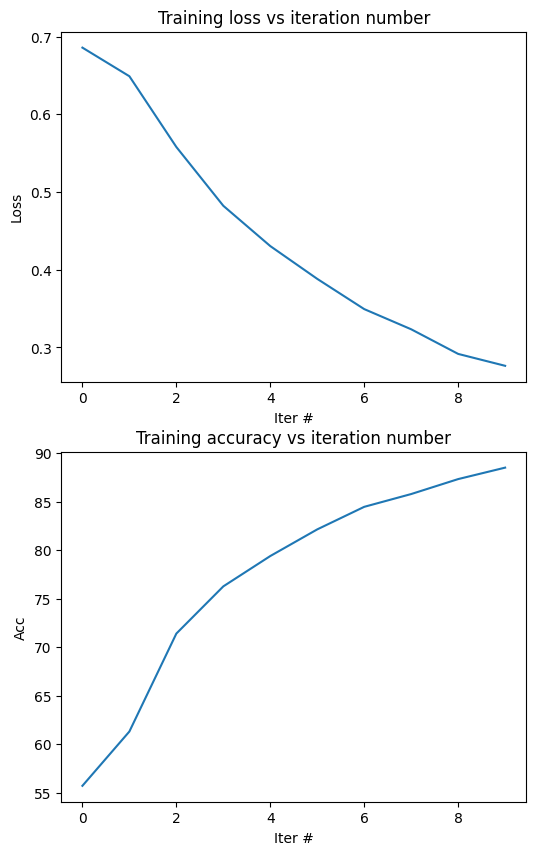

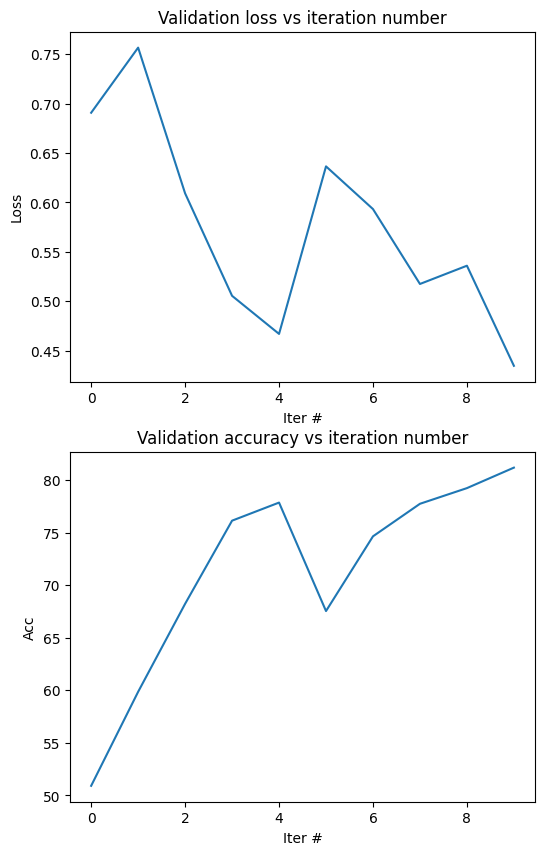

In [ ]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.2
hidden_dim = 128 # use this as hidden layer dimension
num_layers = 3

model = None
#################################
## TODO: initialize model      ##
#################################
model = NLayerMLP(len(word2id), hidden_dim, 2, num_layers)
model = model.to(device)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6869232832933917
Accuracy: 55.78256544269403
Validation Loss: 0.6944097280502319
Validation Accuracy: 50.917431192660544


Loss: 0.68658597022295
Accuracy: 55.78256544269403
Validation Loss: 0.697834312915802
Validation Accuracy: 50.917431192660544


Loss: 0.6863927443822225
Accuracy: 55.78256544269403
Validation Loss: 0.699838399887085
Validation Accuracy: 50.917431192660544


Loss: 0.6863286802262971
Accuracy: 55.78256544269403
Validation Loss: 0.7021154761314392
Validation Accuracy: 50.917431192660544


Loss: 0.6865113174373453
Accuracy: 55.78256544269403
Validation Loss: 0.6977912187576294
Validation Accuracy: 50.917431192660544


Loss: 0.6862561325683738
Accuracy: 55.78256544269403
Validation Loss: 0.7000458836555481
Validation Accuracy: 50.917431192660544


Loss: 0.686510877627315
Accuracy: 55.78256544269403
Validation Loss: 0.6961160898208618
Validation Accuracy: 50.917431192660544


Loss: 0.6863807394649043
Accuracy: 55.78256544269403
Validation Loss: 0.6961296796798706

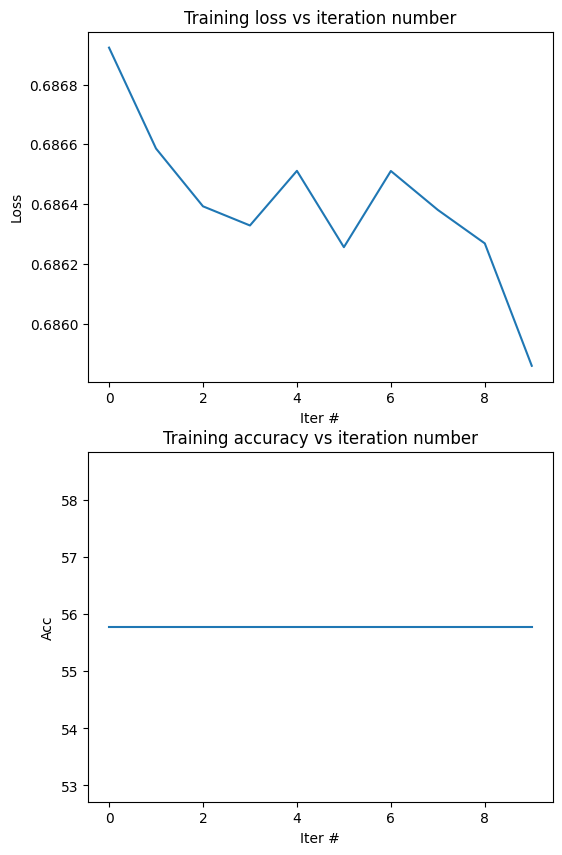

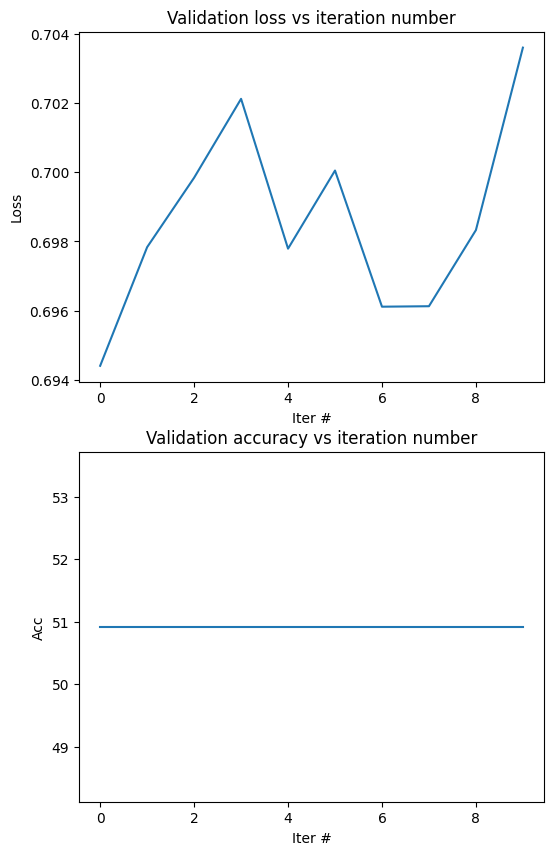

In [ ]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.1
hidden_dim = 128 # use this as hidden layer dimension
num_layers = 5

model = None
#################################
## TODO: initialize model      ##
#################################
model = NLayerMLP(len(word2id), hidden_dim, 2, num_layers)
model = model.to(device)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 2.0244751369411293
Accuracy: 56.31857934045049
Validation Loss: 0.7263208031654358
Validation Accuracy: 60.77981651376147


Loss: 0.8671567209742286
Accuracy: 61.1842789054032
Validation Loss: 0.6500802636146545
Validation Accuracy: 65.02293577981652


Loss: 0.7353288759336327
Accuracy: 64.17318742668785
Validation Loss: 0.6228545904159546
Validation Accuracy: 67.43119266055045


Loss: 0.6862654588890799
Accuracy: 65.89852856018649
Validation Loss: 0.6067414879798889
Validation Accuracy: 68.92201834862385


Loss: 0.6585659265066638
Accuracy: 66.91116423406434
Validation Loss: 0.5926452279090881
Validation Accuracy: 69.38073394495413


Loss: 0.6392661868171259
Accuracy: 67.842135740694
Validation Loss: 0.5823196768760681
Validation Accuracy: 69.61009174311926


Loss: 0.6247522322969004
Accuracy: 68.60829410978634
Validation Loss: 0.5744448304176331
Validation Accuracy: 70.9862385321101


Loss: 0.6130740489020492
Accuracy: 69.32396917548887
Validation Loss: 0.566499650478363
Valida

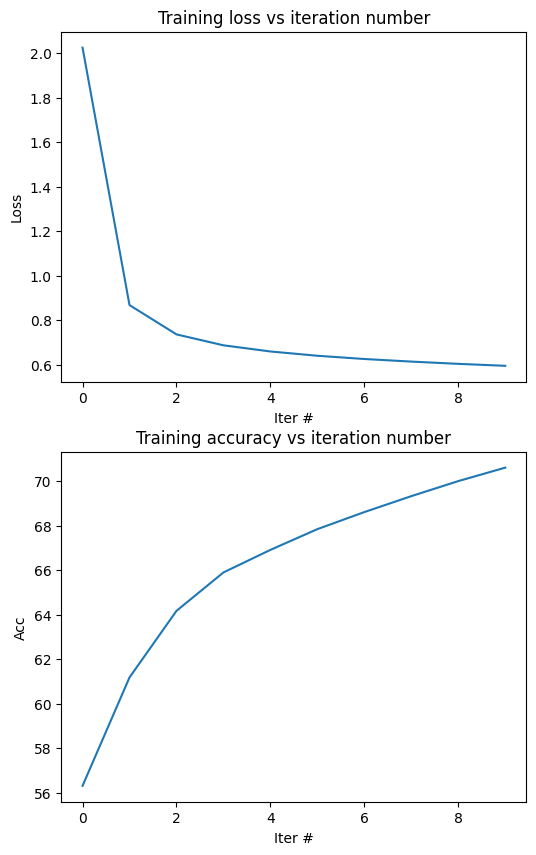

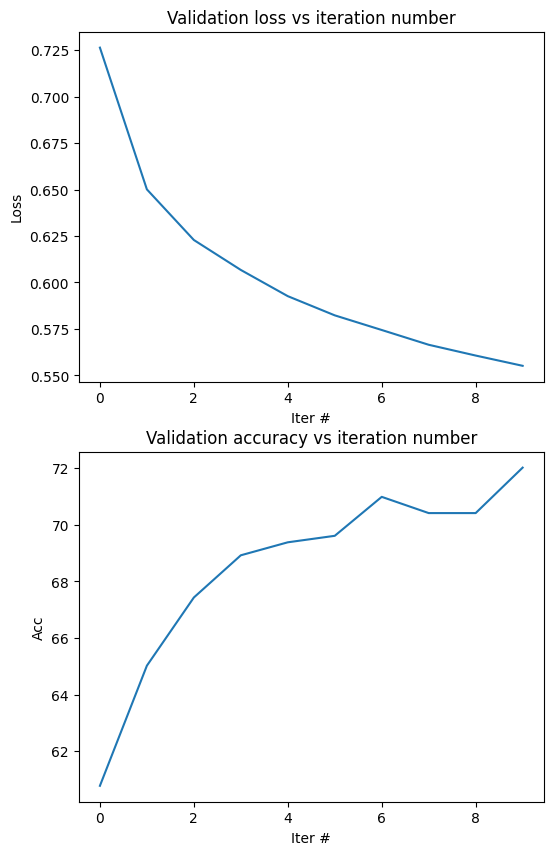

In [ ]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.05
hidden_dim = 128 # use this as hidden layer dimension
num_layers = 10

model = None
#################################
## TODO: initialize model      ##
#################################
model = NLayerMLP(len(word2id), hidden_dim, 2, num_layers)
model = model.to(device)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

Findings:

3 Layers: The validation acc and loss as a lot less jumpy than the 2-layer MLP

5 Layers: For some reason the validation acc and training acc did not move the entire 10 epochs. This is funny since it moves for the 10-layer one. I initially thought the ReLu killed all the weights but it seems that it didn't if the 10-layer MLP works.

10 Layers: Both the training acc and the validation acc were not as high as the 3 and 2 layer MLPs. My only guess would be the choice of non-linearity function/ # of layers being the cause since it is not overfitting or anything.the curves look a lot more stable than all the layers tested before it though.